## Importing

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import glob
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
%matplotlib inline

# Machine Learning Models
import os
import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, MaxPool2D

# Model for Evaluations
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

## Preprocessing

In [2]:
path="Brain Tumor Classification"
categories = os.listdir(path)
print(categories)

['glioma', 'meningioma', 'notumor', 'pituitary']


### Load Data

In [3]:
# Creating dataframe by iterating through filepaths
def create_image_dataframe(dataset_dir):
    data = []
    
    image_extensions = ['*.png', '*.jpg', '*.jpeg',]
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(dataset_dir, '**', ext), recursive=True))
    
    for path in image_paths:
        label = os.path.basename(os.path.dirname(path))
        data.append((label, path))
    
    df = pd.DataFrame(data, columns=['labels', 'filepaths'])
    return df

This [dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data) contains **7023** human brain `MRI images` which are classified into 4 classes: `glioma` - `meningioma` - `no tumor` and `pituitary`.

In [4]:
df = create_image_dataframe(path)
df.head()

,labels,filepaths
0,glioma,Brain Tumor Classification\glioma\Te-glTr_0000...
1,glioma,Brain Tumor Classification\glioma\Te-glTr_0001...
2,glioma,Brain Tumor Classification\glioma\Te-glTr_0002...
3,glioma,Brain Tumor Classification\glioma\Te-glTr_0003...
4,glioma,Brain Tumor Classification\glioma\Te-glTr_0004...


### Class Balance
A **problem** may arise when the number of instances in each `class` of a `dataset` is not balanced. This has a significant impact on the performance of **machine learning models**. The `models` trained on such data tend to be biased towards the `majority class`.

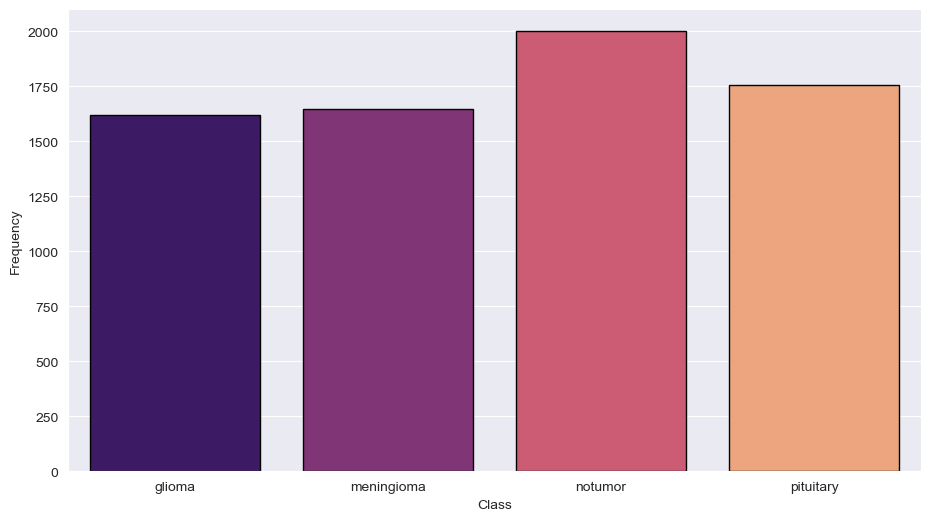

In [5]:
#Choose a style for the plot
sns.set_style("darkgrid")

plt.subplots(figsize=(11, 6))
sns.countplot(x='labels', data=df, hue='labels', palette = "magma", edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Frequency');

It appears that in this case the **data** is 
relatively `balanced`.

In [6]:
# Setup random seed
np.random.seed(50)

#splitting data
train_images, test_images = train_test_split(df, test_size=0.3)
train_set, val_set = train_test_split(df, test_size=0.2)

#shape of splitted data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(5618, 2)
(2107, 2)
(1405, 2)
(4916, 2)


### Data augmentation
**Data augmentation** is a technique used in **machine learning** to artificially increase the size of a **training dataset** by applying various transformations to the existing data. These transformations can include `rotation`, `scaling`, `flipping`, `shifting`, and more, helping to increase the diversity of the training data and improve the model's **generalization ability**.

In [7]:
# Setup random seed
np.random.seed(50)

gen = ImageDataGenerator(rescale=1/255)

train = gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(224,224),
                                      color_mode= 'rgb',
                                      batch_size=32)

test = gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(224,224),
                                     color_mode= 'rgb',
                                     batch_size=32,
                                     shuffle=False)

val = gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(224,224),
                                    color_mode= 'rgb',
                                    batch_size=32)

Found 5618 validated image filenames belonging to 4 classes.
Found 2107 validated image filenames belonging to 4 classes.
Found 1405 validated image filenames belonging to 4 classes.


In [8]:
def show_images(image_gen):
    g_dict = image_gen.class_indices      
    classes = list(g_dict.keys())
    images, labels = next(image_gen)

    plt.figure(figsize= (20, 20))
    for i in range(20):
        plt.subplot(5, 5, i + 1)
        image = images[i]      # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color="black",fontsize=17)
        plt.axis('off')

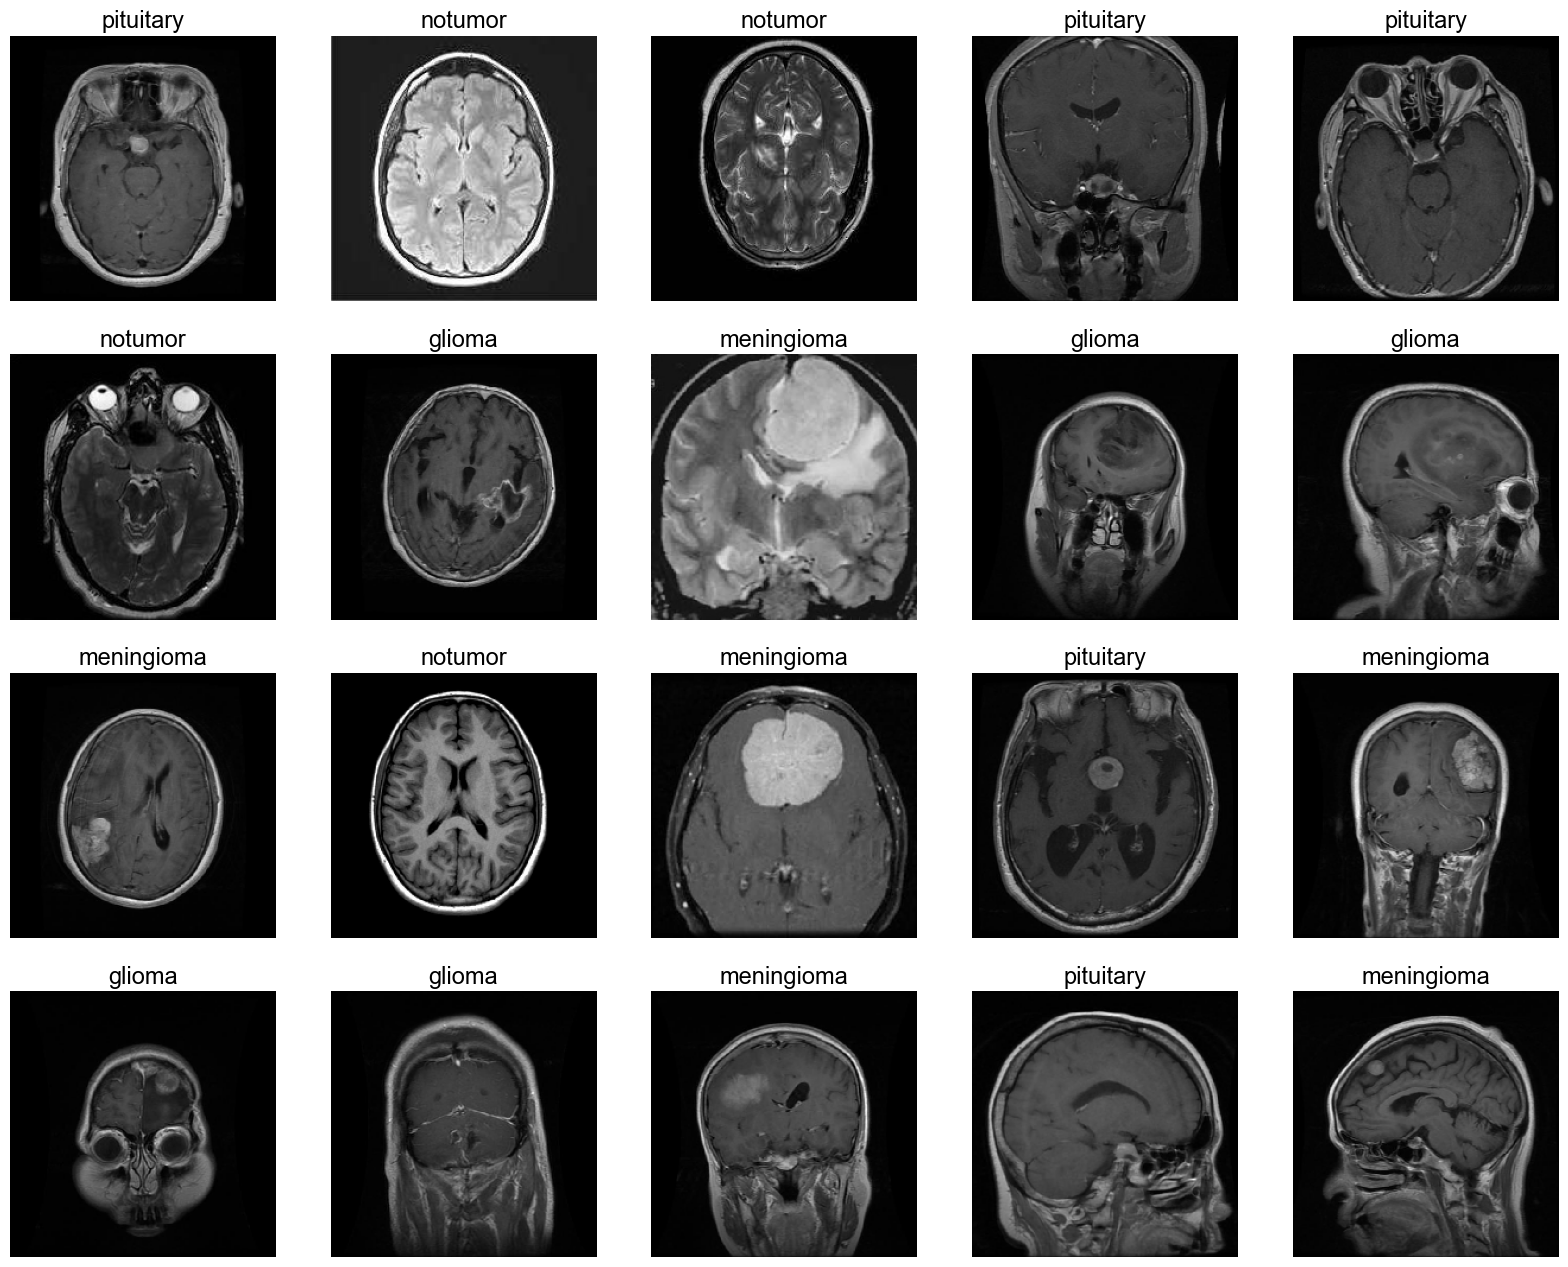

In [9]:
show_images(test)

## Convolutional Neural Network (CNN) 

In [10]:
# Define the CNN model
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=16,kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=16,kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(2,2))

model.add(Flatten())

model.add(Dense(32,activation='relu'))
model.add(Dropout(rate=0.1))

model.add(Dense(16,activation='relu'))
model.add(Dropout(rate=0.1))

model.add(Dense(4,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

C:\Users\User\Desktop\ML-lab\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         346,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354,580 (1.35 MB)

 Trainable params: 354,580 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Setup random seed
np.random.seed(50)

history = model.fit(train, validation_data=val, epochs=10, verbose=1)

Epoch 1/10


C:\Users\User\Desktop\ML-lab\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 89s 486ms/step - accuracy: 0.4917 - loss: 1.0867 - val_accuracy: 0.7616 - val_loss: 0.6067
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.7735 - loss: 0.5560 - val_accuracy: 0.8356 - val_loss: 0.4434
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.8403 - loss: 0.4079 - val_accuracy: 0.8776 - val_loss: 0.3092
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.8859 - loss: 0.3027 - val_accuracy: 0.8847 - val_loss: 0.2907
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.9105 - loss: 0.2394 - val_accuracy: 0.9075 - val_loss: 0.2371
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.9360 - loss: 0.1758 - val_accuracy: 0.9110 - val_loss: 0.3103
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.9445 - loss: 0.1557 - val_accuracy: 0.9210 - val_loss: 0.2202
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 227ms/step - accuracy: 0.9484 - loss: 0.1428 - val

## Evaluate model

In [12]:
def training_history(model):
    train_loss = model.history['loss']
    train_acc = model.history['accuracy']
    val_loss = model.history['val_loss']
    val_acc = model.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    #Choose a style for the plot
    plt.style.use("default")

    # Create a figure and axes with 1 row and 2 columns
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

    ax[0].plot(epochs, train_loss, 'y', label='Training loss')
    ax[0].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[0].set_title('Training and validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend();

    ax[1].plot(epochs, train_acc, 'y', label='Training acc')
    ax[1].plot(epochs, val_acc, 'r', label='Validation acc')
    ax[1].set_title('Training and validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend();

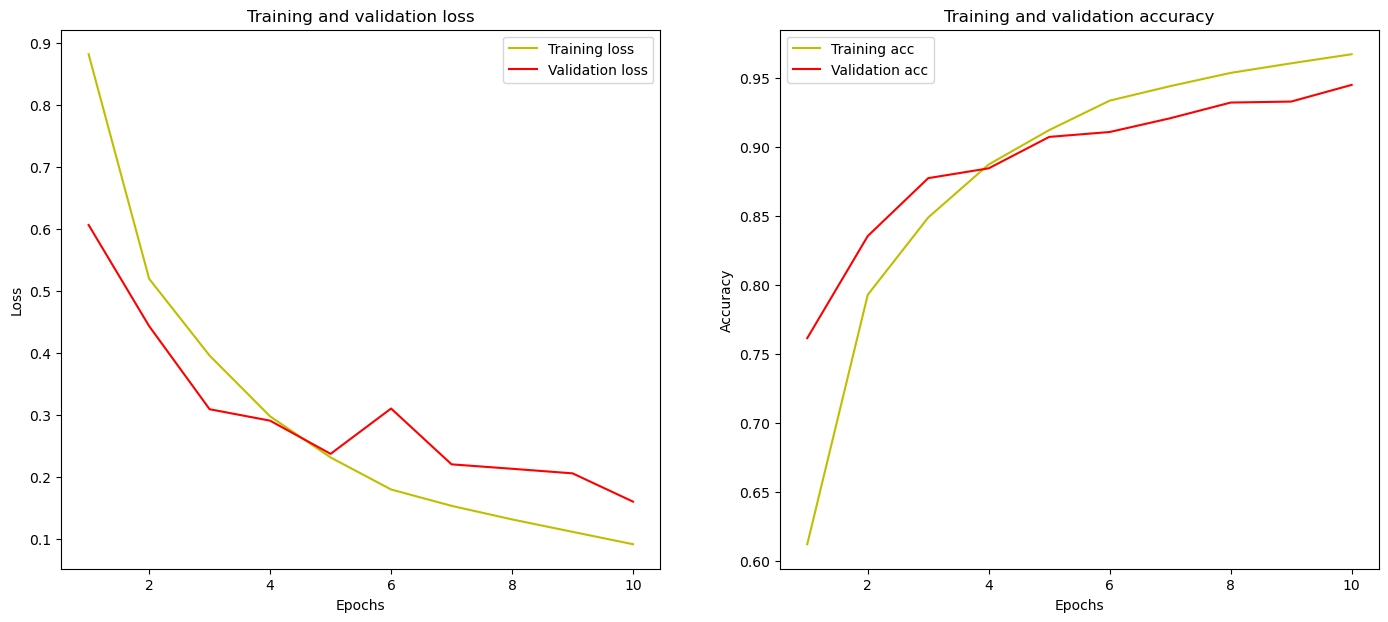

In [13]:
training_history(history)

In [14]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

 1/66 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step

C:\Users\User\Desktop\ML-lab\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step


In [15]:
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")

              precision    recall  f1-score   support

      glioma       0.99      0.96      0.97       458
  meningioma       0.95      0.97      0.96       493
     notumor       0.99      1.00      0.99       612
   pituitary       0.99      0.99      0.99       544

    accuracy                           0.98      2107
   macro avg       0.98      0.98      0.98      2107
weighted avg       0.98      0.98      0.98      2107

Accuracy of the Model: 98.29140958709066 %


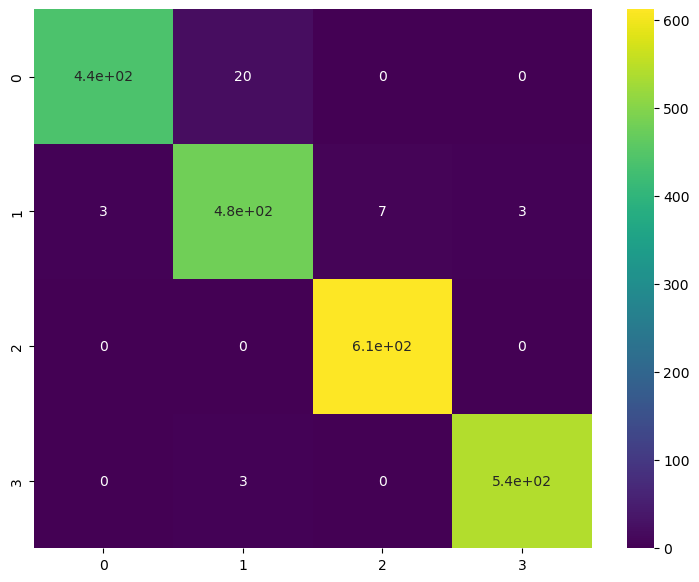

In [16]:
# Making a Confusion Matrix
ConfusionMatrix = confusion_matrix(y_test, pred2)

plt.figure(figsize=(9, 7))
sns.heatmap(ConfusionMatrix, cmap="viridis", annot=True);

## Testing on New Data

In [17]:
def predict(img_path, img_shape, class_names):
    image = load_img(img_path, target_size = (img_shape,img_shape))
    image = np.expand_dims(image,axis=0)
    
    result = np.argmax(model.predict(image/255),axis=1)
    pred_class = class_names[result[0]]

    plt.figure(figsize=(6, 4))
    plt.imshow(load_img(img_path, target_size = (img_shape,img_shape)))
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


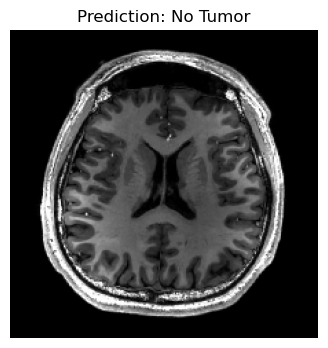

In [18]:
predict('Brain MRI.jpg', 224, ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])